In [2]:
#Compare n(z) HOD galaxies with SRD-Y1 road map n(z)
import numpy as np
import pylab as plt
import pandas as pd

from scipy.integrate import simps
from scipy.interpolate import interp1d
from astropy.table import Table

nzs=np.loadtxt("/global/homes/j/jharno/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/nz_sources_srd_5bins.txt", unpack = True)
z=nzs[0]
nzs_s=nzs[1:]

in_path = '../'
out_path = '../'

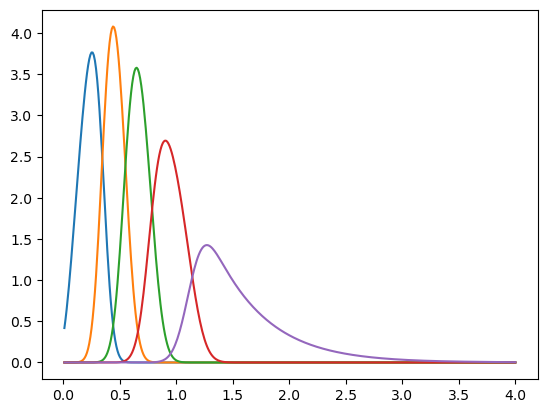

In [3]:
#Plot the SRD-Y1 N(z), normalised to unit area:
for i in range(len(nzs_s)):
    plt.plot(z,nzs_s[i])

In [4]:
#Load the redshifts from the SkySim5000 HOD galaxy catalogue:
#z_HOD = np.loadtxt('../../GalCat/HOD/Joachim_data/GalCat_SkySimHOD_z0_Z3_V1.2.dat',usecols = (0), unpack = True)
z_HOD = np.loadtxt(in_path+'GalCat_SkySimHOD_z0_Z3_V1.2.dat',usecols = (0), unpack = True)

In [5]:
#Make a histogram, normalised to unit area
nz_all,bin_edges = np.histogram(z_HOD, bins=300, range=None, density=None, weights=None)
nz_all_norm = nz_all/sum(nz_all*(bin_edges[1] - bin_edges[0]))

In [6]:
#Load the redshifts from the SkySim5000 HOD galaxy catalogue:
#mag_true_r_lsst = np.loadtxt('../../GalCat/HOD/Joachim_data/GalCat_SkySimHOD_z0_Z3_V1.2.dat',usecols = (18), unpack = True)
mag_true_r_lsst = np.loadtxt(in_path+'GalCat_SkySimHOD_z0_Z3_V1.2.dat',usecols = (18), unpack = True)

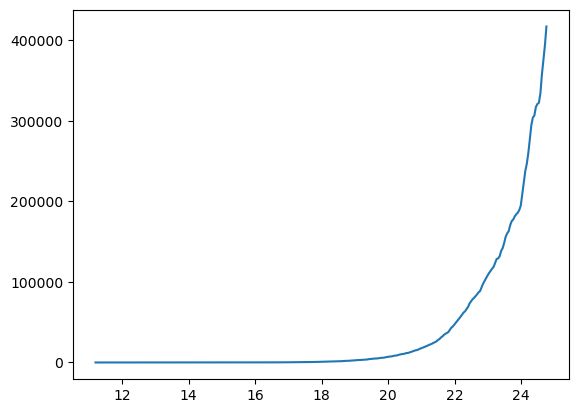

In [7]:
mr_all,mr_bin_edges = np.histogram(mag_true_r_lsst, bins=300, range=None, density=None, weights=None)
plt.plot(mr_bin_edges[:-1],mr_all)


In [8]:
z_HOD_mcut1 = z_HOD[mag_true_r_lsst<24.8]
z_HOD_mcut2 = z_HOD[mag_true_r_lsst<24.6]
z_HOD_mcut3 = z_HOD[mag_true_r_lsst<25.0]

In [9]:
#Make a histogram, normalised to unit area
nz_mcut1,bin_edges_mcut1 = np.histogram(z_HOD_mcut1, bins=300, range=None, density=None, weights=None)
nz_mcut2,bin_edges_mcut2 = np.histogram(z_HOD_mcut2, bins=300, range=None, density=None, weights=None)
nz_mcut3,bin_edges_mcut3 = np.histogram(z_HOD_mcut3, bins=300, range=None, density=None, weights=None)
nz_mcut1_norm = nz_mcut1/sum(nz_all*(bin_edges[1] - bin_edges[0]))
nz_mcut2_norm = nz_mcut2/sum(nz_all*(bin_edges[1] - bin_edges[0]))
nz_mcut3_norm = nz_mcut3/sum(nz_all*(bin_edges[1] - bin_edges[0]))

(0.0, 4.0)

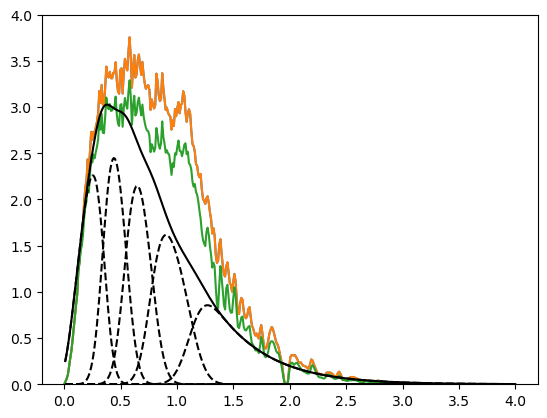

In [10]:
#Overplot the SRD-Y1, normalised to 3.0 gal/arcmin**2 
#(erquiv to 0.6 gal/arcmin**2 in each tomo bin, that is matching the mocks I have made)
#with the N(z) from the HOD galaxies, which currently have 4.1182 gal/arcmin**2.
plt.plot(bin_edges[:-1],nz_all_norm*4.1182*1)
#plt.plot(bin_edges[:-1],nz_all_norm*4.1182*10)
plt.plot(bin_edges_mcut1[:-1],nz_mcut1_norm*4.1182*1, '-')
plt.plot(bin_edges_mcut2[:-1],nz_mcut2_norm*4.1182*1, '-')
#plt.plot(bin_edges_mcut3[:-1],nz_mcut3_norm*4.1182*1, '-')
for i in range(len(nzs_s)):
    plt.plot(z,nzs_s[i]*0.6,'k--')
ax=plt.plot(z,sum(nzs_s)*0.6,'k-')
plt.ylim(0.0, 4.0)


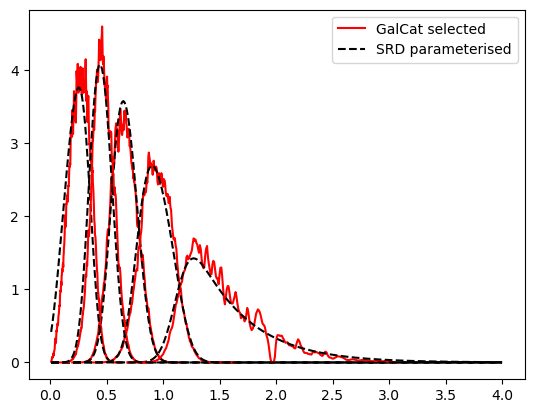

In [11]:
z_HOD_trim = np.sort(z_HOD)
ngals = int((0.6 / 4.1182) * len(z_HOD))

np.random.seed(741428)
# this order was selected through trial and error
# to give the closest match

nz_inds = [2,0,3,4,1]
sel_inds_list = []
full_inds = np.arange(len(z_HOD))
for i in range(len(nzs_s)):
# define target redshift distribution
    target_nz = nzs_s[nz_inds[i]]

    # set up interpolater to get initial selection probabilities for each bin
    dz_interp = interp1d(z, target_nz, fill_value=0, bounds_error=False)

    # interpolate z_HOD to find probability of galaxy being included
    dndz_HOD = dz_interp(z_HOD_trim)

    # select galaxies for bin 1
    sel_weights = dndz_HOD / dndz_HOD.sum()

    # select galaxies based on probabilty for target nz
    sel_inds = np.random.choice(len(z_HOD_trim), size=ngals, p=sel_weights, replace=False)
    sel_z = z_HOD_trim[sel_inds]

    sel_mean = sel_z.mean()
    target_mean = np.average(z, weights=target_nz)

    spow = 20*abs(sel_mean-target_mean)
    if sel_mean < target_mean:
        ratios = (z_HOD_trim / target_mean)**spow
        sel_weights *= ratios
        sel_weights = sel_weights / sel_weights.sum()
    elif sel_mean > target_mean:
        ratios = (target_mean / z_HOD_trim)**spow
        sel_weights *= ratios
        sel_weights = sel_weights / sel_weights.sum()
        
    # select galaxies based on probabilty for target nz
    sel_inds = np.random.choice(len(z_HOD_trim), size=ngals, p=sel_weights, replace=False)
    sel_z = z_HOD_trim[sel_inds]
    og_inds = full_inds[sel_inds]
    sel_inds_list.append(og_inds)
        
    # print((abs(sel_z.mean() - target_mean) / target_mean) * 100)
    # Remove selected inds
    z_HOD_trim = np.delete(z_HOD_trim, sel_inds)
    full_inds = np.delete(full_inds, sel_inds)

    # plot and compare
    sel_nz, sel_bins = np.histogram(sel_z, bins=300, density=None)
    sel_nz_norm = sel_nz/sum(sel_nz*(sel_bins[1] - sel_bins[0]))
    plt.plot(sel_bins[:-1], sel_nz_norm, ls='-', c='r')
    plt.plot(z, target_nz, ls='--', c='k')
    
plt.legend(['GalCat selected','SRD parameterised'])

In [12]:
del mag_true_r_lsst, z_HOD_mcut1, z_HOD_mcut2, z_HOD_mcut3

In [13]:
#FullCat = np.loadtxt(in_path+'GalCat_SkySimHOD_z0_Z3_V1.2.dat', )

FullCat = pd.read_csv(in_path+'GalCat_SkySimHOD_z0_Z3_V1.2.dat', delimiter='\s+', header=0)

#FullCat = Table.read(in_path+'GalCat_SkySimHOD_z0_Z3_V1.2.dat', format='ascii')

In [14]:
FullCat.keys()

Index(['#redshift', 'redshiftHubble', 'redshift_true', 'ra', 'ra_true',
       'is_central', 'dec', 'dec_true', 'shear_1', 'shear_2',
       'shear_2_treecorr', 'shear1', 'shear2', 'tidal_s_11', 'tidal_s_12',
       'tidal_s_22', 'mag_true_r', 'mag_true_r_sdss', 'mag_true_r_lsst'],
      dtype='object')

In [15]:
SortedCat = FullCat.sort_values(by='#redshift')
SortedCat.head(5)

,#redshift,redshiftHubble,redshift_true,ra,ra_true,is_central,dec,dec_true,shear_1,shear_2,shear_2_treecorr,shear1,shear2,tidal_s_11,tidal_s_12,tidal_s_22,mag_true_r,mag_true_r_sdss,mag_true_r_lsst
413246,0.002354,0.002330,0.002330,1.993496,1.993496,True,-36.585871,-36.585871,-0.0,0.0,0.0,-0.0,-0.0,0.124461,-0.123111,0.002861,13.193593,13.201823,13.193593
5507903,0.002971,0.002953,0.002953,13.654109,13.654109,True,-16.923036,-16.923036,-0.0,0.0,0.0,-0.0,-0.0,-0.123335,-1.915698,0.087150,14.282916,14.277528,14.282916
4076523,0.003341,0.003565,0.003565,8.897226,8.897226,True,-12.904038,-12.904038,-0.0,0.0,0.0,-0.0,-0.0,-0.104046,0.627414,-0.104354,15.646408,15.655051,15.646408
1815811,0.004163,0.004073,0.004073,0.239442,0.239442,True,-5.857037,-5.857037,-0.0,0.0,0.0,-0.0,-0.0,0.290030,-0.966089,0.813349,15.330248,15.332679,15.330248
380014,0.004250,0.004422,0.004422,4.069738,4.069738,True,-35.709169,-35.709169,-0.0,0.0,0.0,-0.0,-0.0,0.000550,0.774409,-0.164626,16.410786,16.419580,16.410786


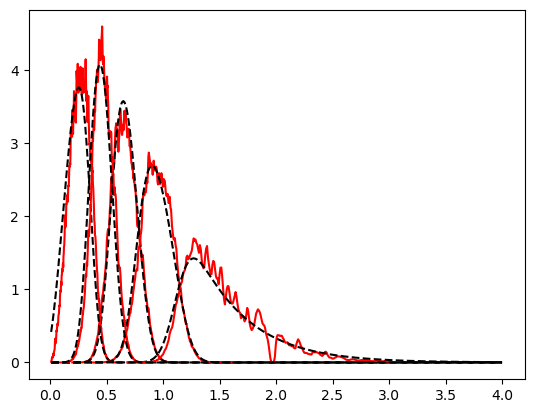

In [16]:
write_data = True

# cut the selected gals and write to .dat file
for i, ind in enumerate(nz_inds):
    target_nz = nzs_s[ind]
    # sel inds list is already ordered correctly
    tomo_bin = SortedCat.iloc[sel_inds_list[i]]
    sel_z = tomo_bin['#redshift']
    sel_nz, sel_bins = np.histogram(sel_z, bins=300, density=None)
    sel_nz_norm = sel_nz/sum(sel_nz*(sel_bins[1] - sel_bins[0]))
    plt.plot(sel_bins[:-1], sel_nz_norm, ls='-', c='r')
    plt.plot(z, target_nz, ls='--', c='k')
    
    if write_data:
        tomo_bin.to_csv(out_path+'GalCat_tomo%d_06GpAM.dat'%(ind+1), index=False, sep=' ')

In [17]:
# check format of saved file
tomoCat = pd.read_csv(in_path+'GalCat_tomo%d_06GpAM.dat'%(3), delimiter='\s+', header=0)
tomoCat.head(5)

,#redshift,redshiftHubble,redshift_true,ra,ra_true,is_central,dec,dec_true,shear_1,shear_2,shear_2_treecorr,shear1,shear2,tidal_s_11,tidal_s_12,tidal_s_22,mag_true_r,mag_true_r_sdss,mag_true_r_lsst
0,0.467090,0.467102,0.467102,12.864998,12.864998,True,-33.770108,-33.770108,0.006197,-0.002465,-0.002465,0.006197,0.002465,-0.033542,-0.160070,-0.031050,24.588505,24.594240,24.588505
1,0.747111,0.750420,0.750420,19.343298,19.343298,True,-31.452984,-31.452984,0.012039,0.008871,0.008871,0.012039,-0.008871,-0.000446,-0.135097,0.388908,22.130522,22.159042,22.130522
2,0.520026,0.517816,0.517816,18.167986,18.167986,True,-25.159453,-25.159453,0.000492,0.008762,0.008762,0.000492,-0.008762,-1.029777,2.398607,1.201188,23.694365,23.697126,23.694365
3,0.473168,0.472050,0.472050,19.804229,19.804229,True,-3.643194,-3.643194,-0.001359,0.001243,0.001243,-0.001359,-0.001243,0.035578,-0.123446,-0.115868,23.266815,23.269274,23.266815
4,0.612385,0.612944,0.612944,10.333385,10.333385,True,-20.121157,-20.121157,0.006094,-0.013537,-0.013537,0.006094,0.013537,-0.255932,0.153213,0.340995,23.676670,23.697523,23.676670


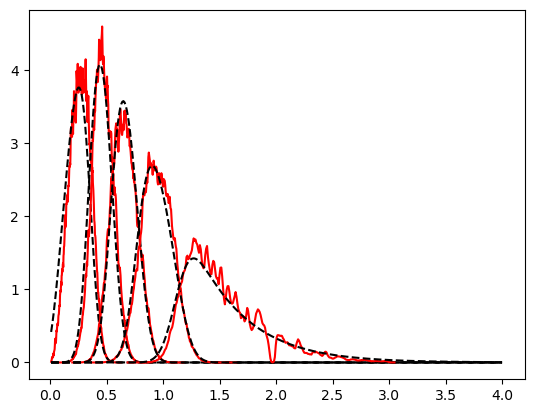

In [18]:
# read in the saved data and plot to make sure it has formatted correctly
for i in range(len(nzs_s)):
    target_nz = nzs_s[i]
    tomotab = pd.read_csv(in_path+'GalCat_tomo%d_06GpAM.dat'%(i+1), delimiter='\s+', header=0)
    
    sel_z = tomotab['#redshift']
    
    sel_nz, sel_bins = np.histogram(sel_z, bins=300, density=None)
    sel_nz_norm = sel_nz/sum(sel_nz*(sel_bins[1] - sel_bins[0]))
    plt.plot(sel_bins[:-1], sel_nz_norm, ls='-', c='r')
    plt.plot(z, target_nz, ls='--', c='k')